<a href="https://colab.research.google.com/github/AndrewFatula/OpenCV_Face_Swapper/blob/master/reface_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import dlib
import zipfile
from matplotlib import pyplot as plt

from PIL import Image
from io import StringIO

!pip3 install dlib
import dlib
print(dlib.DLIB_USE_CUDA)

True


In [3]:
from google.colab import drive

drive.mount('/content/gdriv')

Mounted at /content/gdriv


In [4]:
!cp "/content/gdriv/My Drive/shape_predictor_68_face_landmarks.dat" .

In [10]:
gdriv_path = "/content/gdriv/My Drive/Face_swapper_project/"

image1 = "faces1.png"
image2 = "faces2.jpg"
image3 = "faces3.jpg"
image4 = "faces4.png"
image5 = "faces5.jpg"
image6 = "faces6.jpg"
image7 = "faces7.jpg"
image8 = "faces8.jpg"
image9 = "faces9.jpg"
image10 = "faces10.jpeg"

image_names = [image1, image2, image3, image4, image5, image6, image7, image8, image9, image10]

images = []
for image_name in image_names:
    images.append(cv2.imread(gdriv_path+image_name))



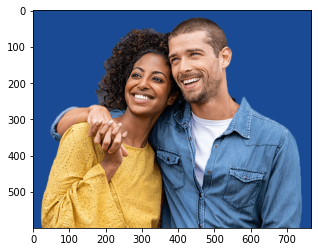

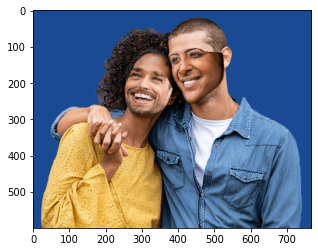

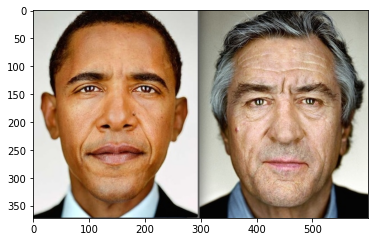

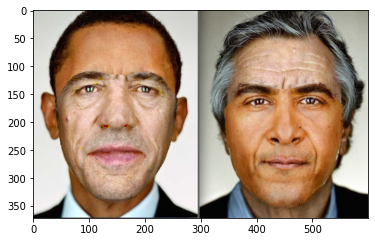

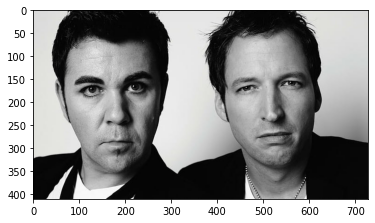

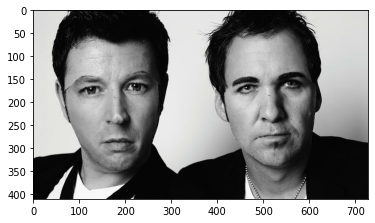

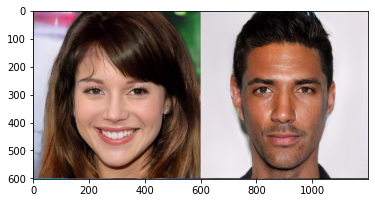

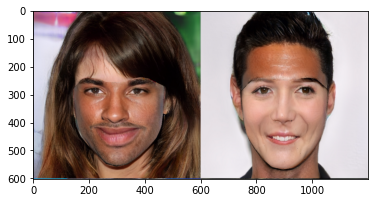

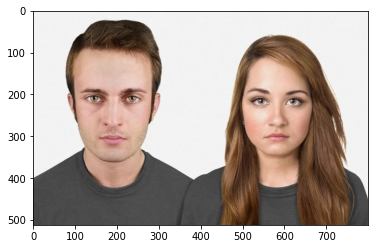

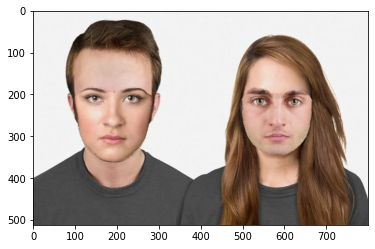

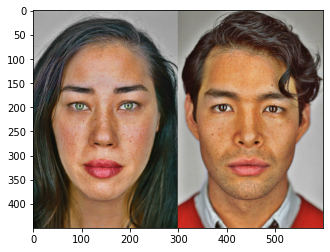

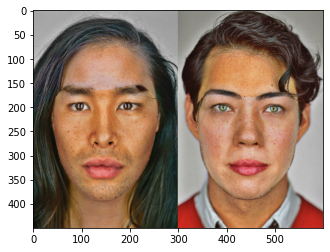

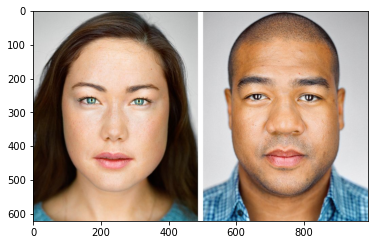

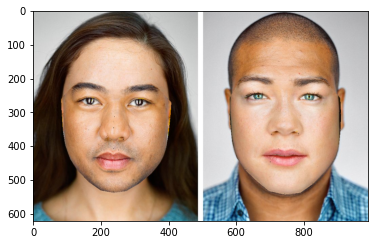

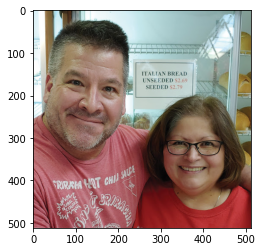

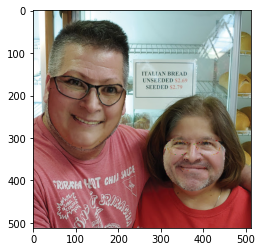

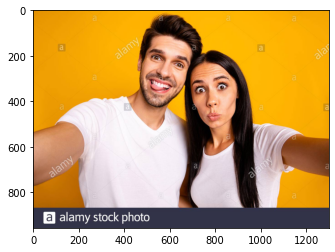

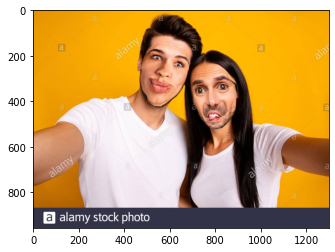

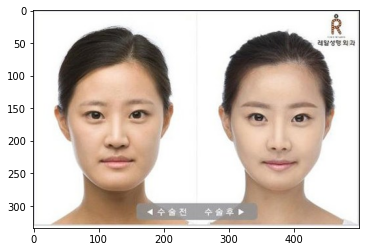

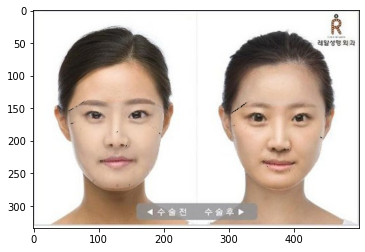

In [11]:



def face_swapper(images_, remove_triangles=True):
    """
    Function, which takes array if images as argument and demonstrates faces swapping on each image
    params:
        images - array of images with faces;
        (IMPORTANT):
        remove_triangles - bool, optional (if set to False - face swapping executes much faster)
    """


    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    for img_idx in range(len(images)):
        img = images.pop(0)[:, :, ::-1]

        plt.imshow(img)
        plt.show()

        res = swap_faces(img, detector, predictor, remove_triangles)
        if not res == None:
            swapped_img, all_landmarks_points = res
        else:
            continue
        if remove_triangles:
            swapped_img = inpaint_landmarks(swapped_img, all_landmarks_points)

        plt.imshow(swapped_img)
        plt.show()








def swap_faces(img, detector, predictor, remove_triangles=True):
    """
    Function which swaps two faces on input image and returns cleaned image.
    params:
        img - image with two faces;
        detector - detector for detecting each face;
        predictor - predictor for predicting landmarks_points.
    return:
        img_swapped - image with swapped faces;
        indices_triangles - indices of landmarks_points needed to build triangles on each face with the same order.
        all_landmarks_points - predicted with predictor landmark_points of each face on the image.
    """
    #convert image to grayscale and detect faces on image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(img_gray)
    mask = np.zeros_like(img_gray)

    #if two faces on the image
    if len(faces) == 2:
        face1 = faces[0]
        face2 = faces[1]
        #get landmarks of first face and indices for buildin triangles
        landmarks_points1, indices_triangles = get_indices_triangles(img_gray, face1, mask, predictor)
        #get landmarks of second face
        landmarks2 = predictor(img_gray, face2)
        landmarks_points2 = []
        for n in range(0, 61):
            x = landmarks2.part(n).x
            y = landmarks2.part(n).y
            landmarks_points2.append((x, y))
        all_landmarks_points = [landmarks_points1, landmarks_points2]

        ### now we need to cut out each face from image copy
        img_swapped = img.copy()
        #ordering landmarks_points in order to get correct contour of each face
        points1 = np.array(all_landmarks_points[0], dtype=np.int32)
        points2 = np.array(all_landmarks_points[1], dtype=np.int32)
        part2_1 = points1[17:27, :]
        part2_2 = points2[17:27, :]
        #extracting face contours from landmarks
        face_contour1 = np.vstack([points1[:17, :], part2_1[::-1]])
        face_contour2 = np.vstack([points2[:17, :], part2_2[::-1]])
        #cutting out each face
        cv2.fillPoly(img_swapped, [face_contour1], 0)
        cv2.fillPoly(img_swapped, [face_contour2], 0)

        #swaping faces and getting all_components
        swap_warped_triangles(img, img_swapped, all_landmarks_points, indices_triangles, remove_triangles)
        return img_swapped, all_landmarks_points

def swap_warped_triangles(img, img_swapped, all_landmarks_points, indices_triangles, remove_triangles):
    """
    Function which crops each triangle from face on image, transforms it, and move it to another face for each face
    on image
    params:
        img - RGB image with faces;
        all_landmark_points - predicted landmark_points for each face on the image;
        indices_triangles - indices of landmarks_points needed to build triangles on each face with the same order.
        remove_triangles - optional for cleaning warped triangles
    """
    triangle_idx = 0
    for triangle_indices in indices_triangles:
        n_matches = 0
        for vertex in triangle_indices:
            if vertex in [18, 19, 20, 21, 22, 23, 24, 25]:
                n_matches += 1
        if n_matches == 3:
            continue

        tr_pts = [[], []]
        triangles = [None, None]# ---------------------> triangles (each triangle is a list of 3 indices of landmarks)
        cropped_triangles = [None, None]# -------------> cropped triangles pair ( for each face )
        rects = [None, None]# -------------------------> rectangles parameters pair
        triangle_points = [None, None]# ---------------> triangle_points in rectangle pair
        warped_triangle = [None, None]# ---------------> warped_triangle pair

        for face_idx in range(2):
            for vertex_idx in range(3):
                tr_pts[face_idx].append(all_landmarks_points[face_idx][triangle_indices[vertex_idx]])
            triangles[face_idx] = np.array([tr_pts[face_idx][0], tr_pts[face_idx][1], tr_pts[face_idx][2]], np.int32)
            rects[face_idx] = cv2.boundingRect(triangles[face_idx])

        for face_idx in range(2):
            x, y, w, h = rects[face_idx]
            cropped_triangles[face_idx] = img[y: y + h, x: x + w]
            # making mask for each triangle
            cropped_tr_mask = np.zeros((h, w), np.uint8)
            cropped_tr_mask = cropped_tr_mask[:cropped_triangles[face_idx].shape[0],
                                              :cropped_triangles[face_idx].shape[1]]
            triangle_points[face_idx] = np.array([[tr_pts[face_idx][i][0] - x, tr_pts[face_idx][i][1] - y]
                                                  for i in range(3)], np.float32)
            # convert all pixels of rectangle to zero except triangle area
            cv2.fillConvexPoly(cropped_tr_mask, np.array(triangle_points[face_idx], np.int32), 255)
            cropped_triangles[face_idx] = cv2.bitwise_and(cropped_triangles[face_idx], cropped_triangles[face_idx],
                                               mask=cropped_tr_mask)
        for face_idx in range(2):

            x2, y2, w2, h2 = rects[abs(face_idx - 1)]
            #creating (2,3) warping matrix
            M = cv2.getAffineTransform(triangle_points[face_idx],
                                       triangle_points[abs(face_idx-1)])
            #applying warping step on cropped_triangles
            warped_triangle[face_idx] = cv2.warpAffine(cropped_triangles[face_idx], M, (w2, h2))

            #size alignment for each warped triangle
            shape = img_swapped[y2: y2 + h2, x2: x2 + w2].shape
            warped_triangle[face_idx] = warped_triangle[face_idx][:shape[0], : shape[1]]
            #pixels alignment for each warped triangle
            warped_triangle[face_idx] = np.where(cropped_triangles[abs(face_idx - 1)] > 0, warped_triangle[face_idx], 0)

            # optional (removes all intersections between triangles)
            if remove_triangles:
                clear_intersection(warped_triangle[face_idx])

            img_rect_area = img_swapped[y2: y2 + h2, x2: x2 + w2]
            #pixels alignment for each img_rect_area
            img_rect_area = np.where(cropped_triangles[abs(face_idx - 1)] == 0, img_rect_area, 0)
            #adding each warped triangle depending on its location
            img_swapped[y2: y2 + h2, x2: x2 + w2] = cv2.add(img_rect_area, warped_triangle[face_idx])
        triangle_idx += 1

def get_indices_triangles(img_gray, face, mask, predictor):
    """
    Function which builds triangles for first image, and constructs list of indices for each triangle
                                            in order to build traingles on second face in the same order
    params: img_gray - gray_scale image with faces;
        face - bbox(x, y, width, height) of first face in img_gray ;
        mask - mask for extracting convexhull face from image.
    return:
        landmarks_points1 - 68 predicted landmarks_points predicted by predictor;
        indices_triangles - indices of landmarks_points1 needed to build triangles.
    """
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 61):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))
    points =np.array(landmarks_points, dtype=np.int32)

    #facial_landmarks of each face have to be in the same order for getting correct contour of face
    part2 = points[17:27, :]
    convexhull = np.vstack([points[:17, :], part2[::-1]])
    #drawing face contour on mask image
    cv2.fillPoly(mask, [convexhull], 255)

    #getting region of interest for building triangles
    rect = cv2.boundingRect(convexhull)
    # needed steps for getting list of triangles built from landmarks_points
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    #after this step each triangle in indices_triangles will be represented as 3 indices of landmarks_points
    indices_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)
        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)
        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if not index_pt1 == None and not index_pt2 == None and not index_pt3 == None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indices_triangles.append(triangle)

    return landmarks_points, indices_triangles

def extract_index_nparray(nparray):
    """
    params : nparray(int) - np.array of indices returned by np.where
    return : index - retrieved indices from np.where
    """
    index =  nparray[0][0]
    return index

def clear_intersection(warped_triangle):
    """
    Function which cleans each cropped triangle from intersections with others triangles
    """
    #making borders of warped triangle more contrast on vertical axis
    condition11 = (tf.roll(warped_triangle, shift=1, axis=1) == 0) & (warped_triangle > 0)
    condition21 = (tf.roll(warped_triangle, shift=-1, axis=1) == 0) & (warped_triangle > 0)
    warped_triangle[:, :, :] = tf.where(condition11, tf.roll(warped_triangle, shift=-1, axis=1), warped_triangle)
    warped_triangle[:, :, :] = tf.where(condition21, tf.roll(warped_triangle, shift=1, axis=1), warped_triangle)

    #making borders of warped triangle more contrast on horizontal axis
    condition12 = (tf.roll(warped_triangle, shift=1, axis=0) == 0) & (warped_triangle > 0)
    condition22 = (tf.roll(warped_triangle, shift=-1, axis=0) == 0) & (warped_triangle > 0)
    warped_triangle[:, :, :] = tf.where(condition12, tf.roll(warped_triangle, shift=-1, axis=0), warped_triangle)
    warped_triangle[:, :, :] = tf.where(condition22, tf.roll(warped_triangle, shift=1, axis=0), warped_triangle)


def inpaint_landmarks(swapped_img, all_landmarks_points):
    """
    Function which inpaints lost pixels after swapping faces.
    params:
        swapped_img - image with swapped faces and triangles;
        all_landmarks_points - all landmark_points for each face predicted with predictor;
    return:
        swapped_img - inpainted image with swapped faces.
    """
    mask_image = np.zeros((swapped_img.shape[0], swapped_img.shape[1]))
    all_landmarks_points = np.concatenate(all_landmarks_points, axis=0)
    for point in all_landmarks_points:
        cv2.circle(mask_image, tuple(point), 0, 255, 3)
    mask_image = np.uint8(mask_image)
    swapped_img = cv2.inpaint(swapped_img, mask_image, 3, flags=cv2.INPAINT_NS)
    return swapped_img


face_swapper(images)